In [3]:
from cl_explain.explanations.contrastive_corpus_similarity import ContrastiveCorpusSimilarity
from cl_explain.explanations.weighted_score import WeightedScore
from cl_explain.attributions.rise import RISE
from captum.attr import IntegratedGradients
import torchvision.transforms as transforms
from collections import OrderedDict
from PIL import Image

import matplotlib.pyplot as plt
import IPython.display
import numpy as np
import skimage
import torch
import clip
import os

RESULT_PATH = "/projects/leelab/cl-explainability/results"
CLIP_DATA_PATH = "/projects/leelab/cl-explainability/archive/clip_use_case"
device = 6  # Which GPU to use
model, preprocess = clip.load("ViT-B/32")
model.cuda(device).eval();

### Helper functions

In [8]:
def load_explicand(explicand_name):
    skimages = ["astronaut", "camera"]
    clip_images = [
        "dog_cat",
        "dogs",
        "zebra",
        "bee",
        "mountain",
        "boy_and_girl",
        "boy_and_girl1",
        "boy_and_girl2",
        "bicycle_and_car",
        "bicycle_and_car1",
        "bicycle_and_car2",
    ]
    if explicand_name in skimages:
        image_path = skimage.data_dir
        explicand_fname = explicand_name + ".png"
    elif explicand_name in clip_images:
        image_path = CLIP_DATA_PATH
        explicand_fname = explicand_name + ".jpg"
    else:
        raise NotImplementedError(
            f"{explicand_name} explicand_name is not implemented!"
        )
    explicand_raw = Image.open(os.path.join(image_path, explicand_fname)).convert("RGB")
    explicand = torch.unsqueeze(preprocess(explicand_raw).cuda(device), 0)
    
    return(explicand_raw, explicand)

def load_attribution(
    explicand_name, 
    corpus_name, 
    foil_name, 
    target_name, 
    attribution_name, 
    seed=123
):
    # Set up result path
    result_path = os.path.join(RESULT_PATH, "clip_use_case", f"{seed}")
    explicand_result_path = os.path.join(
        result_path, f"explicand_{explicand_name}"
    )
    fname = f"{corpus_name}_vs_{foil_name}_"
    fname += f"{target_name}_{attribution_name}"
    result_fname = os.path.join(explicand_result_path, fname + ".pt")
    attribution = torch.load(result_fname, map_location="cpu")
    return(attribution)

### Add rows to plot

In [87]:
# Assuming four columns
rows = []
rows.append({
    "explicand_name": "astronaut",
    "experiments": [
        {
            "corpus_name": "none",
            "foil_name": "none",
            "target_name": "self_weighted",
            "attribution_name": "rise"
        }, 
        {
            "corpus_name": "woman",
            "foil_name": "cifar100",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
        {
            "corpus_name": "rocket",
            "foil_name": "cifar100",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
    ]
})

rows.append({
    "explicand_name": "zebra",
    "experiments": [
        {
            "corpus_name": "none",
            "foil_name": "none",
            "target_name": "self_weighted",
            "attribution_name": "rise"
        }, 
        {
            "corpus_name": "zebra",
            "foil_name": "cifar100",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
        {
            "corpus_name": "stripes",
            "foil_name": "cifar100",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
    ]
})

rows.append({
    "explicand_name": "bicycle_and_car1",
    "experiments": [
        {
            "corpus_name": "none",
            "foil_name": "none",
            "target_name": "self_weighted",
            "attribution_name": "rise"
        }, 
        {
            "corpus_name": "bicycle",
            "foil_name": "cifar100",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
        {
            "corpus_name": "car",
            "foil_name": "cifar100",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
    ]
})

rows.append({
    "explicand_name": "bee",
    "experiments": [
        {
            "corpus_name": "none",
            "foil_name": "none",
            "target_name": "self_weighted",
            "attribution_name": "rise"
        }, 
        {
            "corpus_name": "bee",
            "foil_name": "flower",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
        {
            "corpus_name": "flower",
            "foil_name": "bee",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
    ]
})

rows.append({
    "explicand_name": "dog_cat",
    "experiments": [
        {
            "corpus_name": "none",
            "foil_name": "none",
            "target_name": "self_weighted",
            "attribution_name": "rise"
        }, 
        {
            "corpus_name": "dog",
            "foil_name": "cat",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
        {
            "corpus_name": "cat",
            "foil_name": "dog",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
    ]
})

rows.append({
    "explicand_name": "mountain",
    "experiments": [
        {
            "corpus_name": "none",
            "foil_name": "none",
            "target_name": "self_weighted",
            "attribution_name": "rise"
        }, 
        {
            "corpus_name": "mountain",
            "foil_name": "cloud",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
        {
            "corpus_name": "cloud",
            "foil_name": "mountain",
            "target_name": "contrastive_corpus",
            "attribution_name": "rise"
        },
    ]
})

### Plot rows

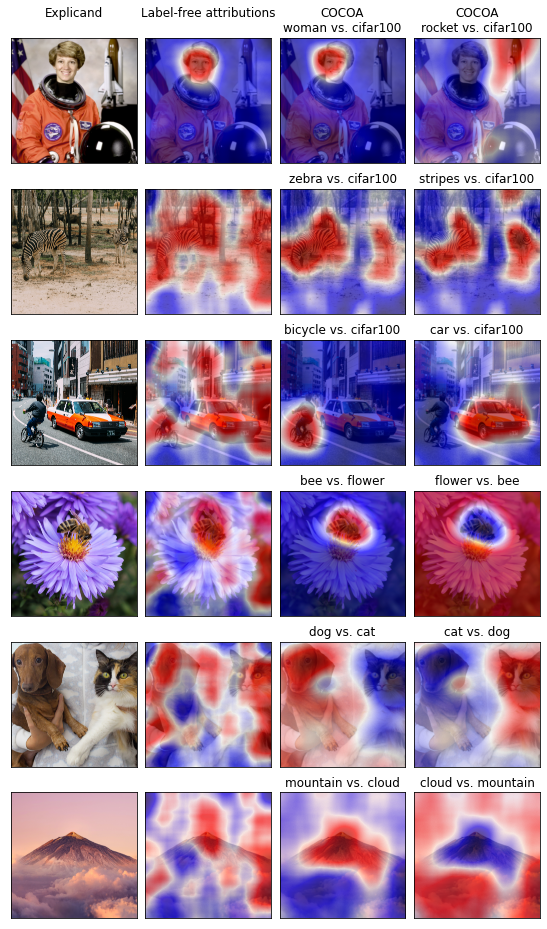

In [109]:
# Figure parameters
fig_size = 2.7
overlay_alpha = 0.6
n_col, n_row = 4, len(rows)
plt.figure(figsize=(fig_size * n_col, fig_size * n_row))
subplot_idx = 1
is_first_row = True

for row_idx, row in enumerate(rows):
    
    # Plot explicand
    explicand_raw, explicand = load_explicand(row["explicand_name"])
    plt.subplot(n_row, n_col, subplot_idx)
    plt.imshow(explicand_raw)
    plt.xticks([])
    plt.yticks([])
    if is_first_row:
        plt.title("Explicand\n")
    subplot_idx += 1

    # Plot attributions
    for experiment_idx, experiment in enumerate(row["experiments"]):
        attribution = load_attribution(
            row["explicand_name"], 
            experiment["corpus_name"], 
            experiment["foil_name"], 
            experiment["target_name"], 
            experiment["attribution_name"], 
            seed=123
        )
        flat_attribution = attribution.cpu()[0].mean(0)
        transform = transforms.Compose(preprocess.transforms[:-1])
        m1, m2 = flat_attribution.min(), flat_attribution.max()

        plt.subplot(n_row, n_col, subplot_idx)
        plt.imshow(transform(explicand_raw).permute(1, 2, 0))
        plt.imshow(
            flat_attribution, 
            vmin=m1, 
            vmax=m2, 
            cmap="seismic", 
            alpha=overlay_alpha)
        plt.xticks([])
        plt.yticks([])
        
        title = ""
        if experiment["target_name"] == "self_weighted":
            if is_first_row:
                title += "Label-free attributions\n"
                plt.title(title)
        elif experiment["target_name"] == "contrastive_corpus":
            if is_first_row:
                title += "COCOA\n"
            plt.title(title+"{} vs. {}".format(
                experiment["corpus_name"], experiment["foil_name"]))
        subplot_idx += 1
        
    is_first_row = False

plt.subplots_adjust(left=0.3, right=0.99, wspace=0.01, hspace=0.2)
plt.savefig(
    os.path.join(RESULT_PATH, "clip_use_case", "123", "figure.pdf"),
    bbox_inches="tight"
)

In [106]:
?plt.savefig

Signature: plt.savefig(*args, **kwargs)
Docstring:
Save the current figure.

Call signature::

  savefig(fname, *, dpi='figure', format=None, metadata=None,
          bbox_inches=None, pad_inches=0.1,
          facecolor='auto', edgecolor='auto',
          backend=None, **kwargs
         )

The available output formats depend on the backend being used.

Parameters
----------
fname : str or path-like or binary file-like
    A path, or a Python file-like object, or
    possibly some backend-dependent object such as
    `matplotlib.backends.backend_pdf.PdfPages`.

    If *format* is set, it determines the output format, and the file
    is saved as *fname*.  Note that *fname* is used verbatim, and there
    is no attempt to make the extension, if any, of *fname* match
    *format*, and no extension is appended.

    If *format* is not set, then the format is inferred from the
    extension of *fname*, if there is one.  If *format* is not
    set and *fname* has no extension, then the file

In [101]:
RESULT_PATH

'/projects/leelab/cl-explainability/results'

In [104]:
!ls /projects/leelab/cl-explainability/results/clip_use_case/123/

explicand_astronaut	    explicand_boy_and_girl   explicand_dogs
explicand_bee		    explicand_boy_and_girl1  explicand_mountain
explicand_bicycle_and_car   explicand_boy_and_girl2  explicand_zebra
explicand_bicycle_and_car1  explicand_camera
explicand_bicycle_and_car2  explicand_dog_cat
